# Normalizing flows for the scalar example

In [1]:
# Import required packages
import torch, math
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

import sys, os, pickle
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(BASE_DIR)
from assistive_functions import *
from experiments.scalar.loss_functions import LQLossFH
from controllers.abstract import get_controller
from experiments.scalar.LTI_sys import LTI_system
from inference_algs.distributions import GibbsPosterior, GibbsWrapperNF
from experiments.scalar.scalar_assistive_functions import load_data

[INFO] running on CPU


/Users/mahrokh/anaconda3/envs/NOC/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ****** PART 1: GENERAL ******
random_seed = 33
random_state = np.random.RandomState(random_seed)
logger = WrapLogger(None)

# ------ 1. load data ------
T = 10
S = 8
epsilon = 0.2       # PAC holds with Pr >= 1-epsilon
dist_type = 'N biased'
prior_type_b = 'Gaussian_biased_wide'

data_train, data_test, disturbance = load_data(
    dist_type=dist_type, S=S, T=T, random_seed=random_seed,
    S_test=None     # use a subset of available test data if not None
)

print(epsilon, prior_type_b, S)

# ------ 2. define the plant ------
sys = LTI_system(
    A = np.array([[0.8]]),  # num_states*num_states
    B = np.array([[0.1]]),  # num_states*num_inputs
    C = np.array([[0.3]]),  # num_outputs*num_states
    x_init = 2*np.ones((1, 1)),  # num_states*1
)

# ------ 3. define the loss ------
Q = 5*torch.eye(sys.num_states).to(device)
R = 0.003*torch.eye(sys.num_inputs).to(device)
# optimal loss bound
loss_bound = 1
# sat_bound = np.matmul(np.matmul(np.transpose(sys.x_init), Q) , sys.x_init)
sat_bound = torch.matmul(torch.matmul(torch.transpose(sys.x_init, 0, 1), Q), sys.x_init)
if loss_bound is not None:
    logger.info('[INFO] bounding the loss to ' + str(loss_bound))
lq_loss_bounded = LQLossFH(Q, R, T, loss_bound, sat_bound, logger=logger)
lq_loss_original = LQLossFH(Q, R, T, None, None, logger=logger)

# ------ 4. Gibbs temperature ------
gibbs_lambda_star = (8 * S * math.log(1/epsilon))**0.5        # lambda for Gibbs

# ------ 5. controller ------
# define a generic controller
generic_controller = get_controller(
    controller_type='Affine', sys=sys,
    # initialization_std=0.1, # for initializing REN. not important
)


0.2 Gaussian_biased_wide 8
[INFO] bounding the loss to 1


In [3]:
# ****** PART 2: PRIOR ******
from control import dlqr

# ------ prior on weight ------
# center prior at the infinite horizon LQR solution
K_lqr_ih, _, _ = dlqr(
    sys.A.detach().numpy(), sys.B.detach().numpy(),
    Q.detach().cpu().numpy(), R.detach().cpu().numpy()
)
theta_mid_grid = -K_lqr_ih[0,0]
# define prior
prior_dict = {
    'type_w':'Gaussian',
    'weight_loc':theta_mid_grid, 'weight_scale':1,
}

# ------ prior on bias ------
if prior_type_b == 'Uniform':
    prior_dict.update({
        'type_b':'Uniform',
        'bias_low':-5, 'bias_high':5
    })
elif prior_type_b == 'Gaussian_biased_wide':
    prior_dict.update({
        'type_b':'Gaussian_biased',
        'bias_loc':-disturbance['mean'][0]/sys.B[0,0],
        'bias_scale':1.5
    })


In [4]:
prior_dict

{'type_w': 'Gaussian',
 'weight_loc': -7.562163004177712,
 'weight_scale': 1,
 'type_b': 'Gaussian_biased',
 'bias_loc': tensor(-3.),
 'bias_scale': 1.5}

In [5]:
# define target distribution
gibbs_posteior = GibbsPosterior(
    loss_fn=lq_loss_bounded, lambda_=gibbs_lambda_star, prior_dict=prior_dict,
    # attributes of the CL system
    controller=generic_controller, sys=sys,
    # misc
    logger=logger,
)

# Wrap Gibbs distribution to be used in normflows
target = GibbsWrapperNF(
target_dist=gibbs_posteior, train_data=data_train, data_batch_size=None,
    prop_scale=torch.tensor(6.0), prop_shift=torch.tensor(-3.0)
)

weight Normal(loc: tensor([-7.5622]), scale: tensor([1.])) torch.Size([1])
bias Normal(loc: tensor([-3.]), scale: tensor([1.5000])) torch.Size([1])


In [7]:
K = 16
#torch.manual_seed(0)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

flows = []
for i in range(K):
    flows += [nf.flows.Planar((2,))]

# base distribution same as the prior
q0 = nf.distributions.DiagGaussian(2)
state_dict = q0.state_dict()
state_dict['loc'] = torch.tensor(
    [prior_dict['weight_loc'], prior_dict['bias_loc']]
).reshape(1, -1)
state_dict['log_scale'] = torch.log(torch.tensor(
    [prior_dict['weight_scale'], prior_dict['bias_scale']]
)).reshape(1, -1)
q0.load_state_dict(state_dict)
print(q0.state_dict())

# set up normflow
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)
nfm.to(device)
# only used to show vase distribution
nfm_base = nf.NormalizingFlow(q0=q0, flows=[], p=target)
nfm_base.to(device)

OrderedDict({'loc': tensor([[-7.5622, -3.0000]]), 'log_scale': tensor([[0.0000, 0.4055]])})


NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList()
  (p): GibbsWrapperNF()
)

In [8]:
# load
file_path = os.path.join(BASE_DIR, 'experiments', 'scalar', 'saved_results')
filename = dist_type.replace(" ", "_")+'_ours_'+prior_type_b+'_T'+str(T)+'_S'+str(S)+'_eps'+str(int(epsilon*10))+'.pkl'
filename = os.path.join(file_path, filename)
filehandler = open(filename, 'rb')
res_dict = pickle.load(filehandler)
filehandler.close()

res_dict['theta_grid'] = [k[0,0] for k in res_dict['theta_grid']]
res_dict['theta'] = [k[0,0] for k in res_dict['theta']]

theta_grid = np.array(res_dict['theta_grid'])
bias_grid = np.array(res_dict['bias_grid'])
Z_posterior = np.reshape(
    np.array(res_dict['posterior']),
    (len(theta_grid), len(bias_grid))
)
assert abs(sum(sum(Z_posterior))-1)<=1e-5


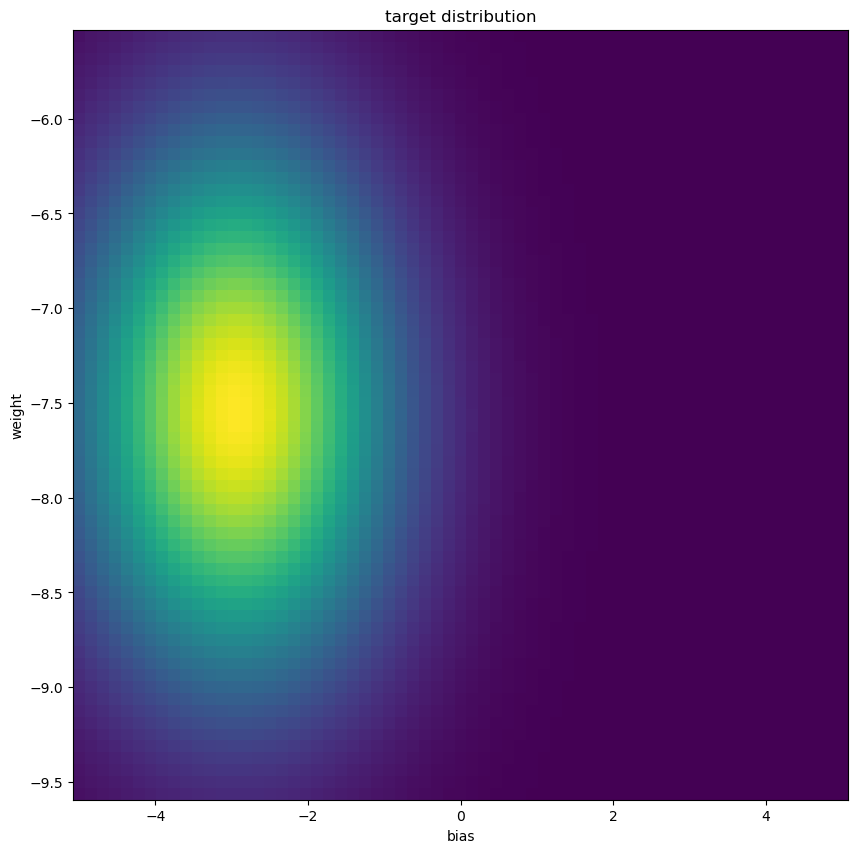

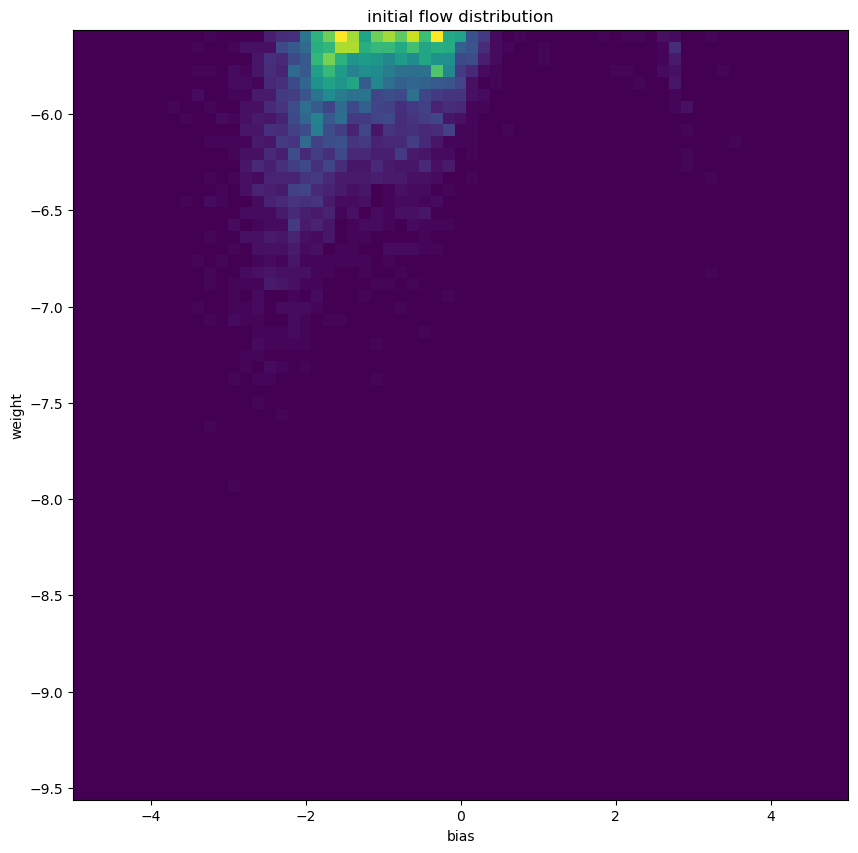

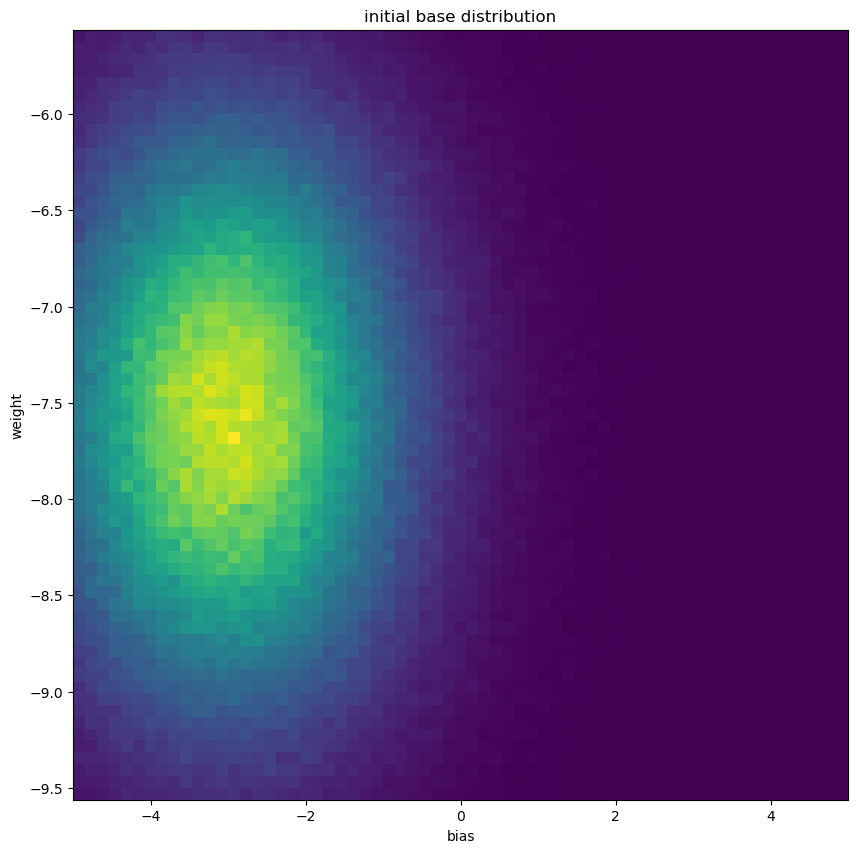

In [9]:
# Plot target distribution
# grid_size = 200
# xx, yy = torch.meshgrid(X, torch.linspace(-3, 3, grid_size))
# z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
# log_prob = target.log_prob(z.to(device)).to('cpu').view(*xx.shape)
# prob = torch.exp(log_prob)

plt.figure(figsize=(10, 10))
plt.pcolormesh(bias_grid, theta_grid, Z_posterior, shading='nearest')
plt.xlabel('bias')
plt.ylabel('weight')
plt.title('target distribution')
plt.show()

# Plot initial flow distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(
    z_np[:, 1].flatten(), z_np[:, 0].flatten(), 
    (len(bias_grid), len(theta_grid)), 
    range=[[bias_grid[-1], bias_grid[0]], [theta_grid[-1], theta_grid[0]]]
)
plt.xlabel('bias')
plt.ylabel('weight')
plt.title('initial flow distribution')
plt.show()

# Plot initial base distribution
z, _ = nfm_base.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(
    z_np[:, 1].flatten(), z_np[:, 0].flatten(), 
    (len(bias_grid), len(theta_grid)), 
    range=[[bias_grid[-1], bias_grid[0]], [theta_grid[-1], theta_grid[0]]]
)
plt.xlabel('bias')
plt.ylabel('weight')
plt.title('initial base distribution')
plt.show()

In [13]:
# Train model
max_iter = 20000
num_samples = 2 * 20
anneal_iter = 10000
annealing = True
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = nfm.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        torch.cuda.manual_seed(0)
        z, _ = nfm.sample(num_samples=2 ** 20)
        z_np = z.to('cpu').data.numpy()
        
        plt.figure(figsize=(10, 10))
        plt.hist2d(
            z_np[:, 1].flatten(), z_np[:, 0].flatten(), 
            (len(bias_grid), len(theta_grid)), 
            range=[[bias_grid[-1], bias_grid[0]], [theta_grid[-1], theta_grid[0]]]
        )
        plt.show()

plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

  0%|          | 26/20000 [00:27<5:53:30,  1.06s/it]


KeyboardInterrupt: 

In [ ]:
# Plot learned distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

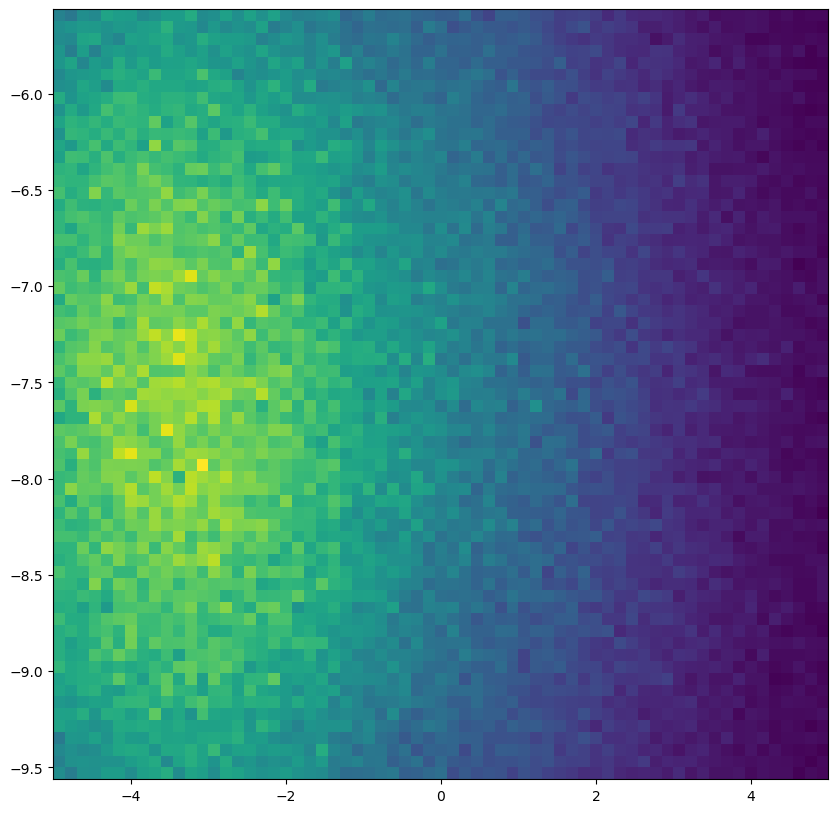

In [12]:
plt.figure(figsize=(10, 10))
plt.hist2d(
    z_np[:, 1].flatten(), z_np[:, 0].flatten(), 
    (len(bias_grid), len(theta_grid)), 
    range=[[bias_grid[-1], bias_grid[0]], [theta_grid[-1], theta_grid[0]]]
)
plt.show()